In [1]:
import os
from bs4 import BeautifulSoup
import requests
import time
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import datetime
import seaborn as sns

In [2]:
url = 'https://ycharts.com/companies/TSLA/revenues'
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"}
response = requests.get(url, headers=headers)
if response.status_code != 200:
    raise Exception(f"Error al acceder a la URL: {url}")

contenido = response.content #scrapped content
soup = BeautifulSoup(contenido, 'html.parser') # consultar para qué querria esto si con pandas lo puedo hacer (en tablas)


In [3]:
#con esto encuentro rapido y facil todas las tablas y puedo manipular mas rapido la info
def extract_data_with_pandas(html_file):
    dfs = pd.read_html(html_file) # Leo todas las tablas del archivo HTML en una lista de DataFrames
    # print(dfs)
    dfs_with_table = []  #un df nuevo para agregarle la variable categorica "TableN" por cada fila (para luego poder filtrar)
    for i, df in enumerate(dfs):  #enumero las tablas que encuentra pandas en el html y por cada fila y tabla, le agrego la linea siguiente
        df['Table'] = f'Table{i+1}'
        dfs_with_table.append(df)
    return dfs_with_table

df = extract_data_with_pandas(contenido)

pd.set_option('display.max_rows', None)
#print(df)

In [4]:
#cumplo con la consigna de "Hazlo utilizando BeautifulSoup"
tables = soup.find_all('table', class_='table') #encuentro las tablas

all_columns = []
data_list = []
table_number = 1
for table in tables : 
    thead = table.find('thead')
    if thead: 
        headers = thead.find_all('th')
    else:
        headers = table.find('tbody').find_all('tr')[0].find_all('th')
    columns = [header.text.strip() for header in headers]
    all_columns.append(columns)
    rows = table.find('tbody').find_all('tr')
    for row in rows:
        columns = row.find_all('td')
        data = [column.text.strip() for column in columns]
        data.insert(0, f"Table{table_number}")
        data_list.append(data)
    table_number += 1
columns = ['Table'] + all_columns[0]
df = pd.DataFrame(columns=columns, data=data_list)

# print(all_columns)
# print(data_list)
# print(df)

df = pd.DataFrame(columns=columns, data=data_list)
df = df.head(50)
df.head()


,Table,Date,Value
0,Table1,"June 30, 2024",25.50B
1,Table1,"March 31, 2024",21.30B
2,Table1,"December 31, 2023",25.17B
3,Table1,"September 30, 2023",23.35B
4,Table1,"June 30, 2023",24.93B


In [5]:
df['Date'] = pd.to_datetime(df['Date'])
#df['Value'] = df['Value'].astype(int)
def convert_dataframe_column_tonums(dataframe, dfcolumn):
    sufixs = {'B': 10**9, 'M': 10**6, 'K': 10**3}
    def convert_values(valuefromlist):
        valuefromlist = valuefromlist.strip().upper()
        if valuefromlist[-1] in sufixs:
            num, sufix = valuefromlist[:-1], valuefromlist[-1]
            return (float(num) * sufixs[sufix]) / 10**6
        else:
            try:
                return float(valuefromlist)/ 10**6
            except ValueError:
                return None
    dataframe['Billions'] = dataframe[dfcolumn].apply(convert_values)
    return dataframe

df_with_nums = convert_dataframe_column_tonums(df, 'Value')
pd.options.display.float_format = '{:,.0f}'.format #porque me gusta visualizarlo asi
df_with_nums.head()


,Table,Date,Value,Billions
0,Table1,2024-06-30,25.50B,"25,500"
1,Table1,2024-03-31,21.30B,"21,300"
2,Table1,2023-12-31,25.17B,"25,170"
3,Table1,2023-09-30,23.35B,"23,350"
4,Table1,2023-06-30,24.93B,"24,930"


In [6]:
df_with_nums.reset_index(drop=True, inplace=True)
print(df_with_nums.head())

    Table       Date   Value  Billions
0  Table1 2024-06-30  25.50B    25,500
1  Table1 2024-03-31  21.30B    21,300
2  Table1 2023-12-31  25.17B    25,170
3  Table1 2023-09-30  23.35B    23,350
4  Table1 2023-06-30  24.93B    24,930


In [7]:
# almaceno los datos en sqlite
conn = sqlite3.connect('mi_base_de_datos.db')
cursor = conn.cursor()

In [8]:
cursor.execute('''
                    CREATE TABLE IF NOT EXISTS tsla_revenue (
                        auto_id INTEGER PRIMARY KEY AUTOINCREMENT,
                        table_name TEXT,
                        date datetime,
                        value TEXT,
                        value_bill FLOAT
                        );
                        ''')
conn.commit()


In [9]:
data_tuples = df_with_nums
data_tuples['Date'] = data_tuples['Date'].dt.strftime('%Y-%m-%d')
data_tuples = list(data_tuples.itertuples(index=False, name=None))
cursor.executemany('''INSERT INTO tsla_revenue (table_name, date, value, 
               value_bill) VALUES (?,?,?,?)''', data_tuples)
conn.commit()

In [10]:
df_consulted = pd.read_sql_query('SELECT * FROM tsla_revenue;', conn)
print(df_consulted.head())
conn.close()

   auto_id table_name        date   value  value_bill
0        1     Table1  2024-06-30  25.50B      25,500
1        2     Table1  2024-03-31  21.30B      21,300
2        3     Table1  2023-12-31  25.17B      25,170
3        4     Table1  2023-09-30  23.35B      23,350
4        5     Table1  2023-06-30  24.93B      24,930


In [11]:
df1 = df_consulted

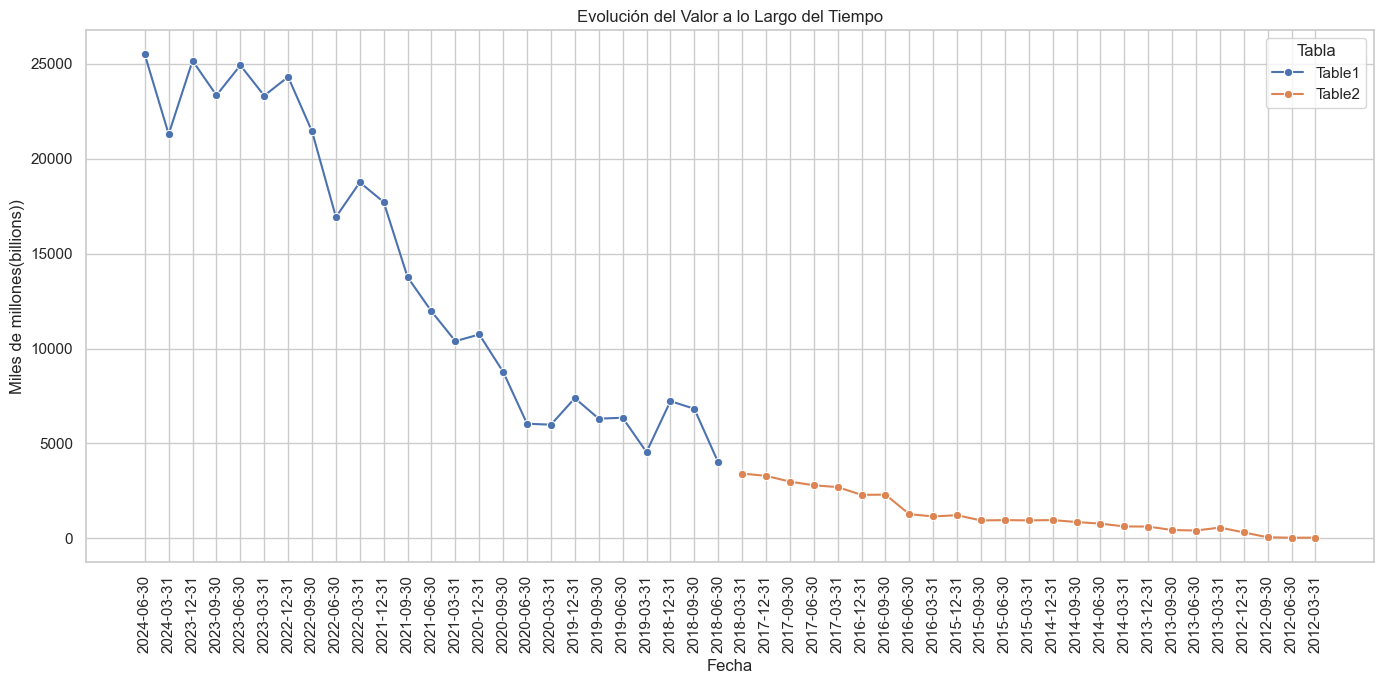

In [12]:
sns.set(style="whitegrid")

plt.figure(figsize=(14, 7))
sns.lineplot(data=df1, x='date', y='value_bill', hue='table_name', marker='o')
plt.title('Evolución del Valor a lo Largo del Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Miles de millones(billions))')
plt.legend(title='Tabla')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [13]:
df1['date'] = pd.to_datetime(df1['date'], errors='coerce')
df1['year'] = df1['date'].dt.year
df1_grouped = df1.groupby(['year', 'table_name']).agg({'value_bill': 'mean'}).reset_index()

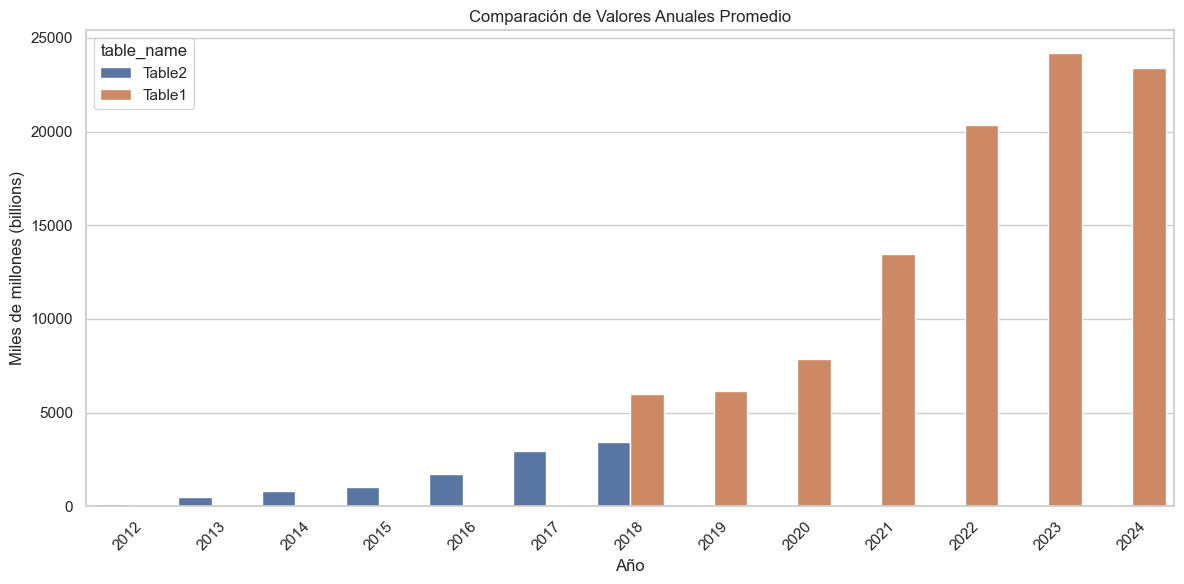

In [14]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df1_grouped, x='year', y='value_bill', hue='table_name')
plt.title('Comparación de Valores Anuales Promedio')
plt.xlabel('Año')
plt.ylabel('Miles de millones (billions)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Program Files\KMSpico\temp\ipykernel_9444\3074563200.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Tabla')


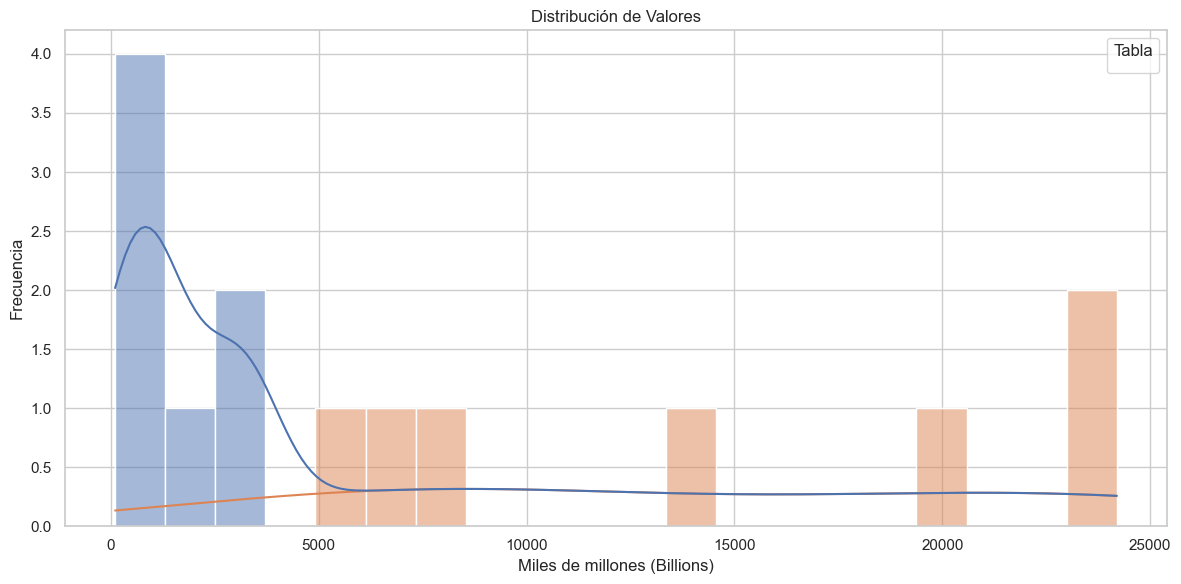

In [15]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df1_grouped, x='value_bill', hue='table_name', multiple='stack', bins=20, kde=True)
plt.title('Distribución de Valores')
plt.xlabel('Miles de millones (Billions)')
plt.ylabel('Frecuencia')
plt.legend(title='Tabla')
plt.tight_layout()
plt.show()


In [22]:
conn.close()